In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)


In [2]:
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

In [3]:
def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

Text(0.5, 0, 'Time (s)')

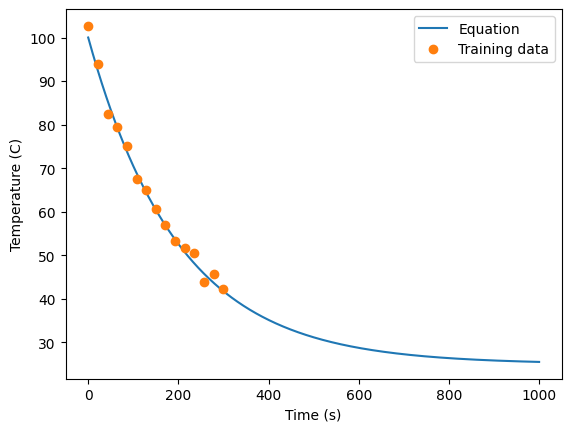

In [4]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0,1000,1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

#Make training data
t = np.linspace(0,300,15)
T = eq(t) + 2 * np.random.randn(15)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Simple feedforward neural network

In [5]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, original loss: 4666.24, second loss: 6775.98, total loss: 11442.22
Epoch 2000/20000, original loss: 9.34, second loss: 3965.60, total loss: 3974.94
Epoch 4000/20000, original loss: 6.84, second loss: 2497.40, total loss: 2504.23
Epoch 6000/20000, original loss: 7.13, second loss: 1719.28, total loss: 1726.41
Epoch 8000/20000, original loss: 5.43, second loss: 1341.85, total loss: 1347.28
Epoch 10000/20000, original loss: 3.11, second loss: 1171.96, total loss: 1175.07
Epoch 12000/20000, original loss: 4.63, second loss: 1075.81, total loss: 1080.44
Epoch 14000/20000, original loss: 4.61, second loss: 1000.58, total loss: 1005.19
Epoch 16000/20000, original loss: 3.98, second loss: 927.81, total loss: 931.78
Epoch 18000/20000, original loss: 4.00, second loss: 858.11, total loss: 862.11


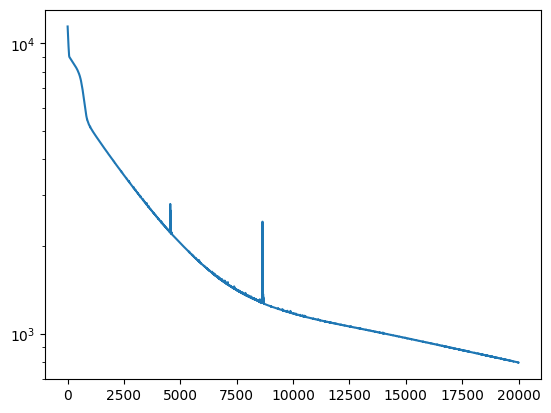

In [6]:
net = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

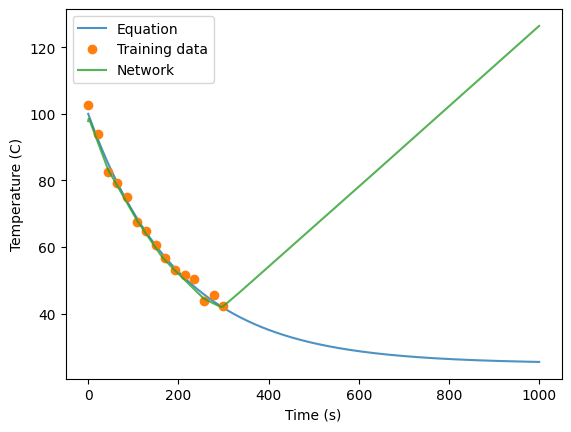

In [7]:
preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Physics informed neural networks

In [8]:
def physics_loss_10(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=10).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

Epoch 0/30000, original loss: 4573.89, second loss: 0.02, total loss: 4573.91
Epoch 3000/30000, original loss: 2121.05, second loss: 1.02, total loss: 2122.06
Epoch 6000/30000, original loss: 121.49, second loss: 21.24, total loss: 142.73
Epoch 9000/30000, original loss: 4.48, second loss: 9.99, total loss: 14.46
Epoch 12000/30000, original loss: 1.34, second loss: 0.32, total loss: 1.65
Epoch 15000/30000, original loss: 1.13, second loss: 0.00, total loss: 1.13
Epoch 18000/30000, original loss: 1.12, second loss: 0.00, total loss: 1.12
Epoch 21000/30000, original loss: 1.10, second loss: 0.00, total loss: 1.10
Epoch 24000/30000, original loss: 1.09, second loss: 0.00, total loss: 1.09
Epoch 27000/30000, original loss: 1.09, second loss: 0.00, total loss: 1.09


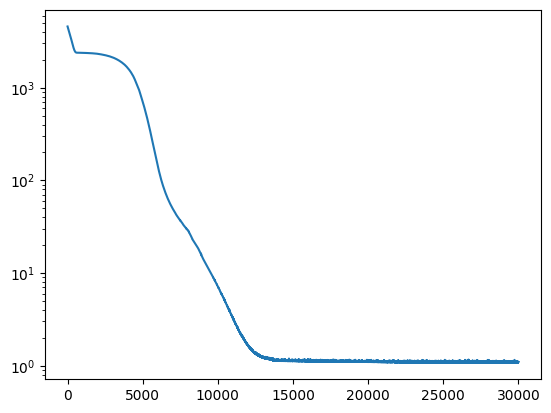

In [9]:
net_1000 = Net(1,1, loss2=physics_loss_10, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses_1000 = net_1000.fit(t, T)
plt.plot(losses_1000)
plt.yscale('log')

In [10]:
colloc_points = np.linspace(0,1000,10)
colloc_temps = eq(colloc_points)

Text(0.5, 0, 'Time (s)')

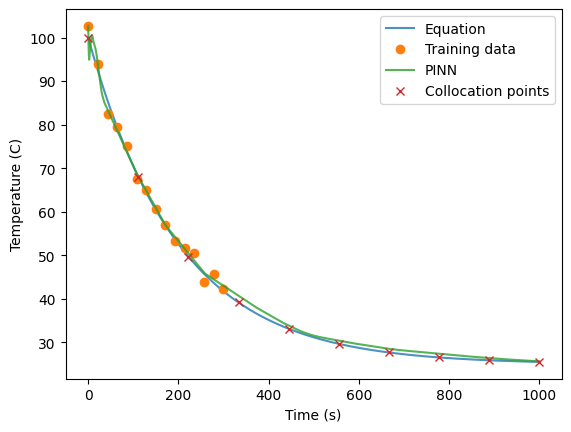

In [11]:
preds = net_1000.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(colloc_points, colloc_temps, 'x')
plt.legend(labels=['Equation','Training data', 'PINN', 'Collocation points'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')